In [48]:
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import optimize

In [49]:
def draw(Ox: list[list], Oy: list[list], names: list[str],
         scatter: bool = False):
    f = plt.figure(figsize=(10, 7))
    px1 = f.add_subplot(111)
    if not scatter:
        for x, y, name in zip(Ox, Oy, names):
            px1.plot(x, y, label=name)
    else:
        for x, y in zip(Ox, Oy, names):
            px1.scatter(x, y, label=name)
    px1.legend()
    f.show()

In [50]:
def fx(xvn, yvn, a):
    return -a*((xvn**3)/3-xvn) + a*yvn

def fy(xvn, yvn, c, b):
    return -xvn + c - b*yvn

In [51]:
"""Явный метод Эйлера 1-го порядка"""
def explicit_method(T, a, xvn, yvn, c, b):
    xn1 = T*fx(xvn, yvn, a) + xvn
    yn1 = T*fy(xvn, yvn, c, b) + yvn
    return (xn1, yn1)

In [52]:
"""Явный метод Рунге-Кутты 4-го порядка"""
def explicit4_method(T, a, xvn, yvn, c, b):
    kx1 = fx(xvn, yvn, a)
    kx2 = fx(xvn + T/2*kx1, yvn + T/2, a)
    kx3 = fx(xvn + T/2*kx2, yvn + T/2, a)
    kx4 = fx(xvn + T*kx3, yvn + T, a)
    xn = xvn + T/6*(kx1 + 2 * kx2 + 2 * kx3 + kx4)

    ky1 = fy(xvn, yvn, c, b)
    ky2 = fy(xvn + T/2, yvn + T/2 * ky1, c, b)
    ky3 = fy(xvn + T/2, yvn + T/2 * ky2, c, b)
    ky4 = fy(xvn + T/2, yvn + T * ky3, c, b)
    yn = yvn + T/6*(ky1 + 2 * ky2 + 2 * ky3 + ky4)
    
    return (xn, yn)

In [53]:
"""Явный метод Рунге-Кутты 5-го порядка"""
def explicit5_method(T, a, xvn, yvn, c, b):
    kx1 = fx(xvn, yvn, a)
    kx2 = fx(xvn + 1/4 * T * kx1,
             yvn + 3/2 * T, a)
    if xvn + (3/32 * kx1 + 9/32 * kx2) * T > 10:
        print(xvn + (3/32 * kx1 + 9/32 * kx2) * T)
    kx3 = fx(xvn + (3/32 * kx1 + 9/32 * kx2) * T,
             yvn + 3/8 * T, a)
    kx4 = fx(xvn + (1932/2197 * kx1 - 
             7200/2197 * kx2 + 7296/2197 * kx3) * T,
             yvn + 12/13 * T, a)
    kx5 = fx(xvn + (439/216 * kx1 - 8 * kx2
                    + 3680/513 * kx3 - 845/4104 * kx4) * T,
                    yvn + T, a)
    kx6 = fx(xvn + (-8/27 * kx1 + 2 * kx2 - 3544/2565 * kx3
                    + 1859/4104 * kx4 + 11/40 * kx5) * T,
                    yvn + 1/2 * T, a)
    xn = xvn + (16/135 * kx1 + 6656/12825 * kx3
                + 28561/56430 * kx4 + 2/55 * kx5
                - 9/50 * kx6) * T
    
    ky1 = fy(xvn, yvn, c, b)
    ky2 = fy(xvn + 3/2 * T,
             yvn + 1/4 * T * ky1, c, b)
    ky3 = fy(xvn + 3/8 * T,
             yvn + (3/32 * ky1 + 9/32 * ky2) * T, c, b)
    ky4 = fy(xvn + 12/13 * T, yvn + (1932/2197 * ky1 - 
            7200/2197 * ky2 + 7296/2197 * ky3) * T, c, b)
    ky5 = fy(xvn + T, yvn + (439/216 * ky1 - 8 * ky2
             + 3680/513 * ky3 - 845/4104 * ky4) * T, c, b)
    ky6 = fy(xvn + 1/2 * T,
             yvn + (-8/27 * ky1 + 2 * ky2 - 3544/2565 * ky3
             + 1859/4104 * ky4 + 11/40 * ky5) * T, c, b)
    yn = yvn + (16/135 * ky1 + 6656/12825 * ky3
                + 28561/56430 * ky4 + 2/55 * ky5
                - 9/50 * ky6) * T

    return (xn, yn)

In [54]:
# TODO: remove list, можно использовать предыдущее значение
def newtonsMethod(a, c, T, y, b, x):
    l = [x]  # list of x(y) values
    for _ in range(100):
        xn = l[-1]  # previous value of x
        y_x = ((-xn+c)*T+y)/(1+b*T)  # y выраженный через х

        f = -xn+(-a*(xn**3/3-xn) + a*y_x)*T+x
        g = -1+a*T*(-T/(b*T+1)-xn**2+1)

        l.append(l[-1] - f/g)
    return l[-1]

In [55]:
"""Неявный метод Эйлера 1-го порядка"""
def implicit_method(T, a, xvn, yvn, c, b):
    xn2 = newtonsMethod(a, c, T, yvn, b, xvn)
    yn2 = (T*(-xn2+c) + yvn)/(1+b*T)
    return (xn2, yn2)

[scipy root](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html),
[Jacobian](<https://math.libretexts.org/Bookshelves/Calculus/Supplemental_Modules_(Calculus)/Vector_Calculus/3%3A_Multiple_Integrals/3.8%3A_Jacobians>)


In [56]:
"""Неявный метод Хаммера-Холлингсворта 2-го порядка"""
def implicit2_method(T, ak, xvn, yvn, ck, bk):
     # Таблица Бутчера
     a = [[1/4, 1/4 - math.sqrt(3)/6],
          [1/4 + math.sqrt(3)/6, 1/4]]
     c = [(1/2 - math.sqrt(3)/6), 1/2 + math.sqrt(3)/6]
     b = [1/2, 1/2]

     # x[0] = kx1, x[1] = kx2
     def fkx(x):
          xvn1 = xvn + T * (a[0][0] * x[0] + a[0][1] * x[1])
          xvn2 = xvn + T * (a[1][0] * x[0] + a[1][1] * x[1])
          # т.к. уравнения равны нулю, вычитаем kx1 и kx2
          return [-ak * ((xvn1) ** 3 / 3 - xvn1) + ak * (yvn + c[0] * T) - x[0],
                  -ak * ((xvn2) ** 3 / 3 - xvn2) + ak * (yvn + c[1] * T)- x[1]]
     
     def jac_fkx(x):
          xvn1 = xvn + T * (a[0][0] * x[0] + a[0][1] * x[1])
          xvn2 = xvn + T * (a[1][0] * x[0] + a[1][1] * x[1])
          # Якобиан системы, частные производные от каждого
          # уравнения по каждой переменной
          return np.array([[-ak * ((xvn1) ** 2 * T * a[0][0] - T * a[0][0]) - 1,
                          -ak * ((xvn1) ** 2 * T * a[0][1] - T * a[0][1])],
                          [-ak * ((xvn2) ** 2 * T * a[1][0] - T * a[1][0]),
                          -ak * ((xvn2) ** 2 * T * a[1][1] - T * a[1][1]) - 1]])


     sol = optimize.root(fun=fkx, x0=[0, 0],
                         jac=jac_fkx, method='hybr')
     xn = xvn + T * (b[0] * sol.x[0] + b[1] * sol.x[1])

     # y[0] = ky1, y[1] = ky2
     def fky(y):
          yvn1 = yvn + T * (a[0][0] * y[0] + a[0][1] * y[1])
          yvn2 = yvn + T * (a[1][0] * y[0] + a[1][1] * y[1])
          return [-(xvn + c[0] * T) + bk * yvn1 + ck - y[0],
                  -(xvn + c[1] * T) - bk * yvn2 + ck - y[1]]
     
     def jac_fky(y):
          return np.array([[bk * T * a[0][0] - 1, bk * T * a[0][1]],
                           [bk * T * a[1][0], bk * T * a[1][1] - 1]])

     sol = optimize.root(fun=fky, x0=[0, 0],
                         jac=jac_fky, method='hybr')
     yn = yvn + T * (b[0] * sol.x[0] + b[1] * sol.x[1])

     return (xn, yn)

In [57]:
# новый шаг
def get_p(array):
    s = sum([i ** 2 for i in array])
    return math.sqrt(s)

# T0 - максимальный возможный шаг
def new_T(last_T, T0, array, array_prev, L):
    p = get_p(array)
    F = [i / p for i in array]
    p_prev = get_p(array_prev)
    F_prev = [i / p_prev for i in array_prev]
    X = [(F[i] - F_prev[i]) / last_T for i in range(len(F))]
    XX = sum([i ** 2 for i in X])
    new_T = T0 / (1 + math.sqrt(L) * XX ** (1/4))
    return new_T

In [58]:
def do_method(method, t_start, t_finish, tl, array, variables, dynamic_step: bool=True):
    T, a, b, c = [i for i in variables]
    max_step = T

    array_T = [T]
    array_dif = [(fx(array[-1][0], array[-1][1], a),
                    fy(array[-1][0], array[-1][1], c, b))]
    while tl[-1] <= t_finish:
        array.append(method(T, a, array[-1][0], array[-1][1], c, b))
        array_dif.append((fx(array[-1][0], array[-1][1], a),
                fy(array[-1][0], array[-1][1], c, b)))
        if dynamic_step:
            T = new_T(array_T[-1], max_step, array[-1], array[-2], t_finish - t_start)
        array_T.append(T)
        tl.append(tl[-1] + T)
    return (tl, array, array_dif)

$x' = -a(\frac{x^3}{3} - x) - ay$\
$y' = -x - by + c$\
$x(0) = 2,\quad y(0) = 0$\
Здесь 1 $\leq$ _a_ $\leq$ 10^3, 0 < _c_ < 1.
Провести исследование поведения решений в зависимости от значений «большого» параметра _a_.


122750 134385 122750 134385


C:\Users\coconut\AppData\Local\Temp\ipykernel_19780\2940713186.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


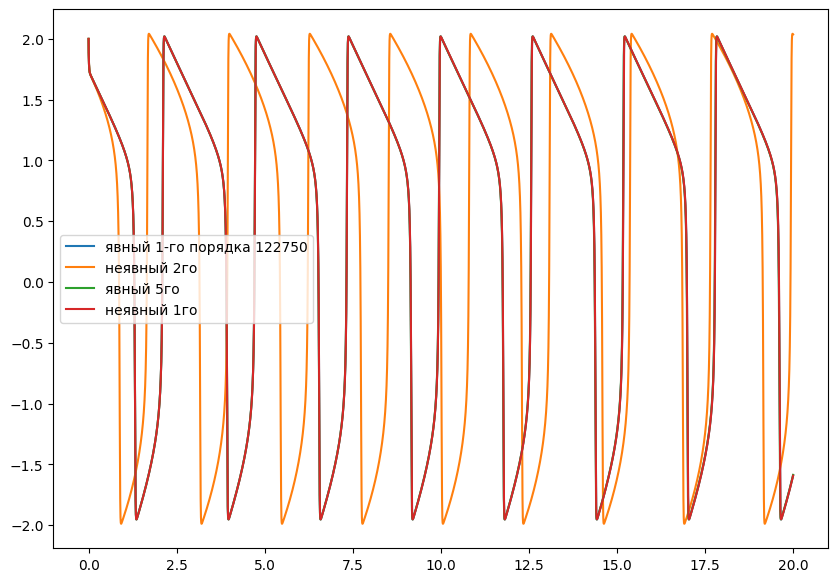

In [59]:
T = 0.001
t_start = 0
t_finish = 20
a = 50
c = 0.5
b = 0.60
# Первый элемент это x, второй y
variables = (T, a, b, c)
array0 = [(2, 0)]
array1 = do_method(explicit_method, t_start, t_finish, [t_start], [(2, 0)], variables)
array2 = do_method(implicit2_method, t_start, t_finish, [t_start], [(2, 0)], variables)

arrayx1 = [i[0] for i in array1[1]]
arrayx2 = [i[0] for i in array2[1]]

# main_array.append(arrayx3)
# print(len(array1[0]), len(array2[0]), len(arrayx1), len(arrayx2))
# array_dif_x3 = [[i[0] for i in array3_dif]]
draw([array1[0], array2[0]],
     [arrayx1, arrayx2],
      [f"явный 1-го порядка {len(array1[0])}", f"неявный 2го"])
# draw(array2[0], [arrayx2], f"неявный 2-го порядка {len(array1[0])}")
# draw(px1, tl, arrayx2, "неявный 1-го порядка")
# draw(tl, [arrayx3], f"{a}, {c} рунге-кутты")
# draw(tl, array_dif_x3, f"{a} x' from t")
# draw(arrayx3, array_dif_x3, "x' from x")

### Сравнение с решением с помощью SciPy


C:\Users\coconut\AppData\Local\Temp\ipykernel_19780\2940713186.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


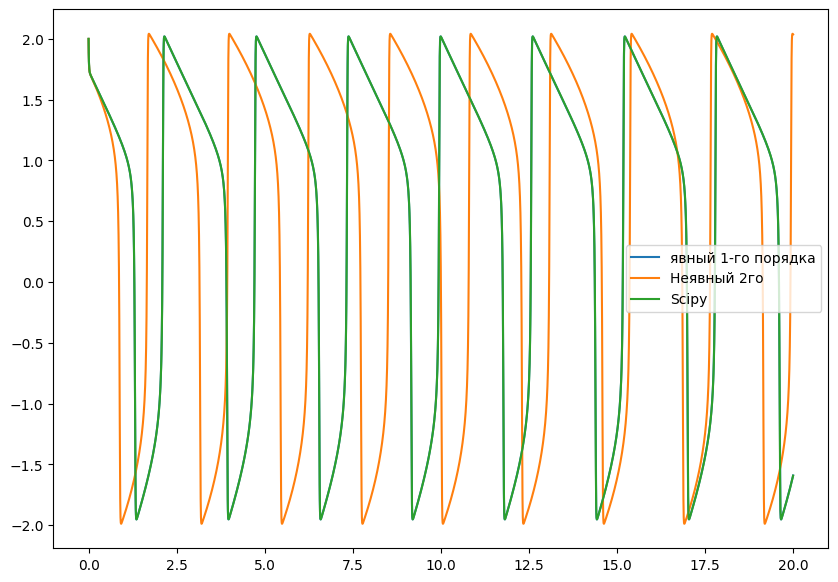

In [63]:
from scipy.integrate import ode

def f(t, y, a, b, c):
  return [a*(y[0] + y[1] - y[0]**3/3),
          c - y[0] - b*y[1]]

def jac(t, y, a, b, c):
  return [[a*(1 - y[0]**2),  a],
          [             -1, -b]]

y01, y02 = 2., 0.
a, b, c = 50., 0.6, 0.5

r = ode(f, jac).set_integrator('vode', method='bdf', with_jacobian=True)
r.set_initial_value((y01, y02)).set_f_params(a, b, c).set_jac_params(a, b, c)

t1, dt, t, y1, y2 = 20, 0.01, [0.], [y01], [y02]
while r.successful() and r.t < t1:
  r.integrate(r.t + dt)
  t.append(r.t)
  y1.append(r.y[0])
  y2.append(r.y[1])

draw([array1[0], array2[0], t],
     [arrayx1, arrayx2, y1],
      [f"явный 1-го порядка", "Неявный 2го", f"Scipy"])

Веселые рисунки


In [61]:
T0 = 0.01
T = 0.001
t_start = 0
t_finish = 100
a = 1
while a <= 1: 
    # a = 100
    # c = 0.59465
    c = 0.6
    b = 0.5
    # Первый элемент это x, второй y
    variables = (T0, T, a, b, c)
    array0 = [(2, 0)]
    # array1 = do_method(explicit_method, t_start, t_finish, [t_start], [(2, 0)], variables)
    array2 = do_method(implicit_method, t_start, t_finish, [t_start], [(2, 0)], variables)
    arrayx2 = [i[0] for i in array2[1]]
    arrayy2 = [i[1] for i in array2[1]]
    arrayx2 = [i[0] for i in array2[1]]
    # arrayx2 = [i[0] for i in array2]
    # arrayx3 = [i[0] for i in array3]
    # arrayx4 = [i[0] for i in array4]

    # main_array.append(arrayx3)
    # print(len(array1[0]), len(array2[0]), len(arrayx1), len(arrayx2))
    # print(len(array2[1]))
    # array_dif_x3 = [[i[0] for i in array3_dif]]
    # draw(array1[0], [arrayx1], f"явный 1-го порядка {len(array1[0])}")
    draw(array2[0], [arrayx2], f"явный 1-го порядка {a}")
    # draw(arrayx2, [[i[0] for i in array2[2]]], "wow")
    draw(arrayx2, [arrayy2], "name")
    draw(arrayx2, [[i[0] for i in array2[2]]], name="x' from x")
    fig = plt.figure()
    # x = np.reshape(arrayx1, (len(), 12))
    # y = np.reshape(arrayy1, (9, 12))
    # z = np.reshape(array1[0], (9, 12))
    ax = fig.add_subplot(111, projection='3d')
    # ax.plot_surface(x, y, z)
    ax.plot(arrayx2, arrayy2, array2[0])
    # ax.set_xlabel('x')
    # ax.set_ylabel('y')
    # ax.set_zlabel('z')
    # draw(px1, tl, arrayx2, "неявный 1-го порядка")
    # draw(tl, [arrayx3], f"{a}, {c} рунге-кутты")
    # draw(tl, array_dif_x3, f"{a} x' from t")
    # draw(arrayx3, array_dif_x3, "x' from x")

    a *= 2

ValueError: too many values to unpack (expected 4)